# X-Ray Chest Image

## Exploratory Data Analysis

Next, we load the medical image dataset that will be used for our analysis, in our case we have X-rays.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision.models as models
from tqdm import tqdm
from torchvision import transforms
import pandas as pd
import torchvision

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget, ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import glob
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage import exposure

In [2]:
Normal = glob.glob('/user/icarrara/home/Documents/Teaching/Intoduction_to_ML/TP_2024/Lesson8/Data/chest_xray/test/NORMAL/*.jpeg') # This will load all the .jpeg files from the NORMAL examples from the train samples directory of the dataset.
Pneumonia = glob.glob('/user/icarrara/home/Documents/Teaching/Intoduction_to_ML/TP_2024/Lesson8/Data/chest_xray/test/PNEUMONIA/*.jpeg') # This will load all the .jpeg files from the Pneumonia examples from the train samples directory of the dataset.

### Data Distribution

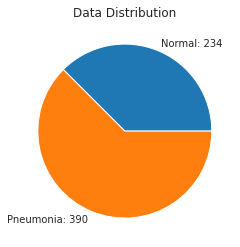

In [3]:
plt.pie(x = (len(Normal), len(Pneumonia)), labels=[f'Normal: {len(Normal)}', f'Pneumonia: {len(Pneumonia)}'])
plt.title("Data Distribution")
plt.show()

### Visualizing Data

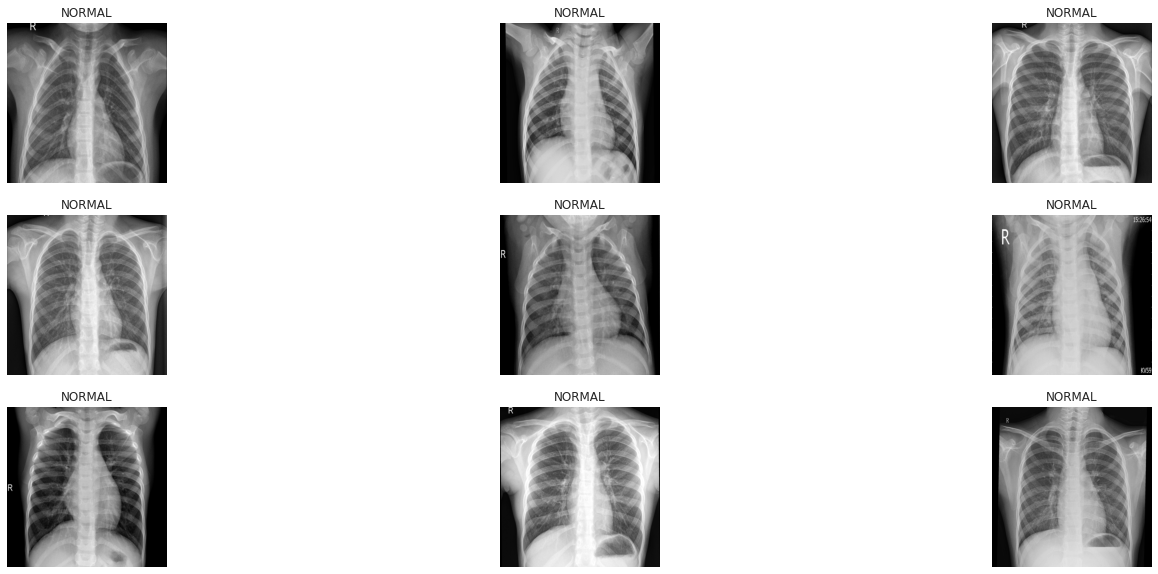

In [4]:
figure = plt.figure(figsize=(25, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(Normal), size=(1,)).item()
    img_path = Normal[sample_idx]
    img = Image.open(img_path).resize((512, 512))
    img = np.array(img)
    figure.add_subplot(rows, cols, i)

    label = img_path.split('/')[-2]
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

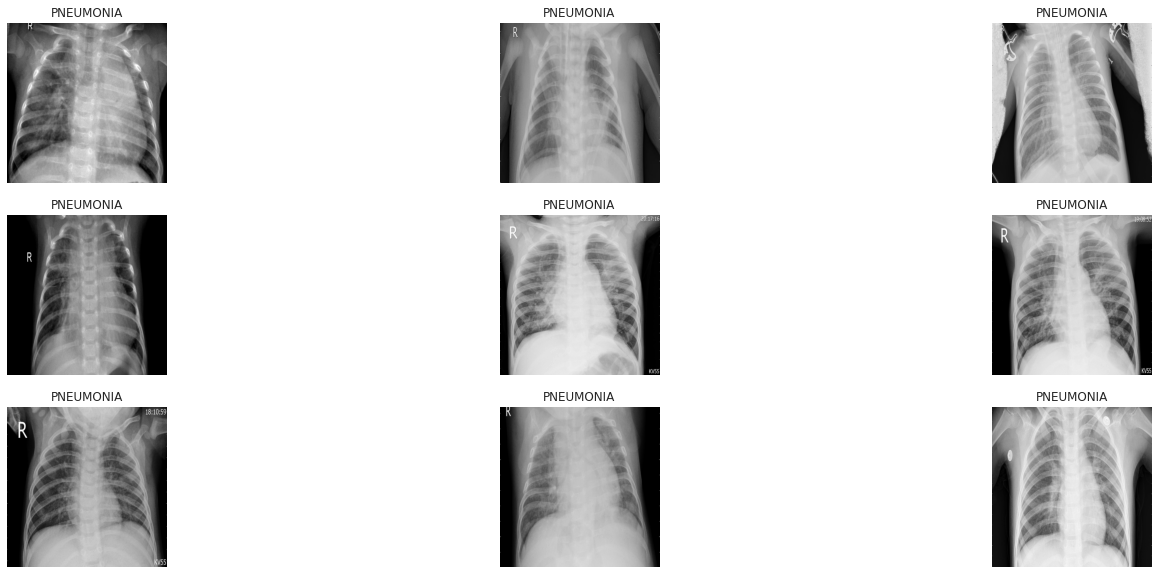

In [5]:
plt.show()
figure = plt.figure(figsize=(25, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(Pneumonia), size=(1,)).item()
    img_path = Pneumonia[sample_idx]
    img = Image.open(img_path).resize((512, 512))
    img = np.array(img)
    figure.add_subplot(rows, cols, i)

    label = img_path.split('/')[-2]
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

# Classification

In [6]:
# Check if GPU is available, otherwise use CPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LABEL_ENCODING = {
    "NORMAL": 0,
    "PNEUMONIA": 1
}

class CXR_Dataset(torch.utils.data.Dataset):
    """
        Class for loading the images and their corresponding labels.
        Parameters:
        image_path (python list): A list contsisting of all the image paths (Normal and Pneunomina combined)
        transform (callable): Data augmentation pipeline.
    """
    def __init__(
        self,
        image_paths,
        transforms=None,
    ):
        super().__init__()
        self.image_paths = image_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        try:
            # Reading the image path and the corresponding label
            img_path = self.image_paths[item]
            label = self.image_paths[item].split('/')[-2] # Splitting the string and extracting the labels (the directory name in our case)
            label = torch.tensor(LABEL_ENCODING[label])
            # Opening the image using Pillow and resizing it to the required size
            img = Image.open(img_path).convert("L").resize((256, 256))
            img = np.array(img)

            # performing Histogram equalization on the Image to utilize the entire pixel range
            img = exposure.equalize_hist(img)

            img = (((img - img.min()) / img.max() - img.min())*255).astype(np.uint8)

            # Stack the Gray scaled 1 channel image 3 times to convert to 3 channel image
            img = np.stack((img, )*3)
            img = np.transpose(img, (1, 2, 0))

            # Performing data augmentation using the transforms pipeline
            img = self.transforms(img)
            return {"img": img, "target": label}

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

In [7]:
def inference(
    model,
    dataloader,
):
    preds = []
    images = []
    gt = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Inference"):
            image = batch["img"].to(DEVICE)
            targets = batch["target"].to(DEVICE)
            y_preds = model(image)
            y_preds = torch.softmax(y_preds, dim=1)
            y_preds = torch.argmax(y_preds, dim=1)
            preds.append(y_preds.cpu())
            images.append(image.cpu())
            gt.append(targets.cpu())

    return images, preds, gt

In [8]:
test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

To make prediction we use a DENSENET architecture, loading the model from torchvision nd changing the head. Then we proceed to train the network on the training data and we save the new model. Here we processo only in loading that model.

In [9]:
test_images = glob.glob('/user/icarrara/home/Documents/Teaching/Intoduction_to_ML/TP_2024/Lesson8/Data/chest_xray/test/*/*.jpeg')

DENSENET121 = torchvision.models.densenet121()
DENSENET121.classifier = nn.Sequential(
        nn.Linear(in_features=(DENSENET121.classifier.in_features),out_features=512),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512,out_features=256),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=256,out_features=128),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=128,out_features=2)
    )


model = DENSENET121
model = model.to(DEVICE)
model_config = torch.load('/user/icarrara/home/Documents/Teaching/Intoduction_to_ML/TP_2024/Lesson8/Models/V0/densenet121/2023-06-30 10_50_46.047269/best_model_config.pth.tar', map_location=DEVICE)
model.load_state_dict(model_config['model_weights'])

test_images = np.random.choice(test_images, size=len(test_images))

dataset = CXR_Dataset(test_images, test_transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=32)

inputs, outputs, gts = inference(model, dataloader)

/user/icarrara/home/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Inference: 100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


/tmp/ipykernel_32378/2049491699.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Label.iloc[i] = label


<Axes: >

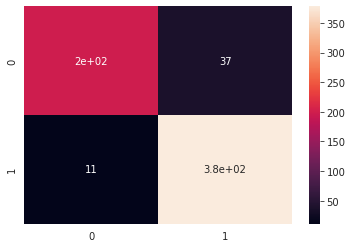

In [11]:
f_list = []

for i in range(10):
    for j in range(64):
        try:
            pred = outputs[i][j]
            if pred.item() == 1:
                f_list.append("PNEUMONIA")

            if pred.item() == 0:
                f_list.append("NORMAL")
        except:
            break

df = pd.DataFrame()
df['image_path'] = test_images
df['preds'] = f_list
df['Label'] = -1
for i in range(len(df)):
    label = df.image_path.iloc[i].split('/')[-2]
    df.Label.iloc[i] = label

df.to_csv('/user/icarrara/home/Documents/Teaching/Intoduction_to_ML/TP_2024/Lesson8/Data/test_preds.csv', index=False)
from sklearn.metrics import confusion_matrix

gt = df.Label
gt = np.array(gt)
pred = df.preds
pred = np.array(pred)
cf_matrix = confusion_matrix(gt, pred)
import seaborn as sns

sns.heatmap(cf_matrix, annot=True)

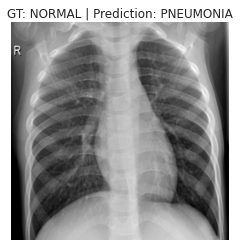

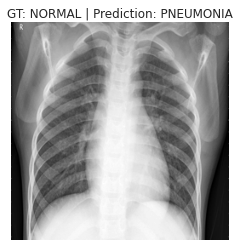

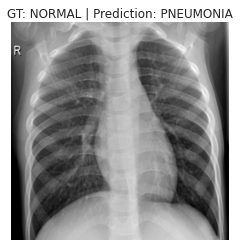

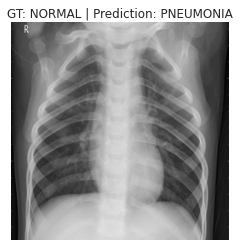

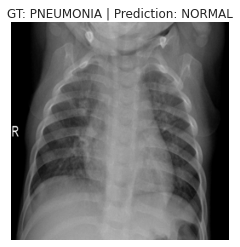

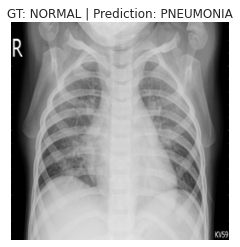

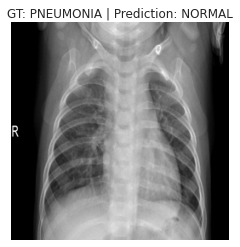

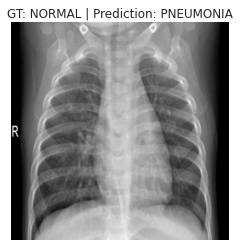

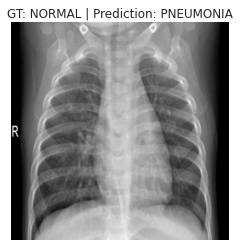

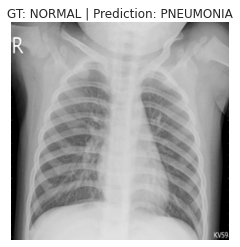

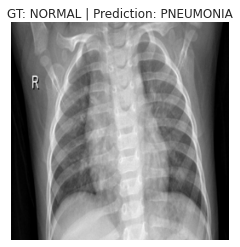

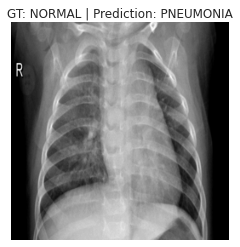

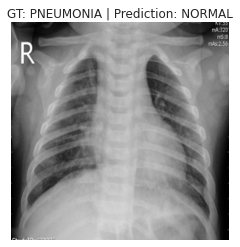

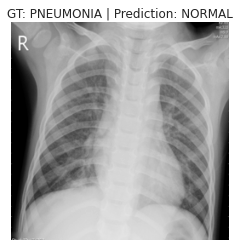

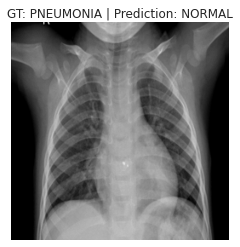

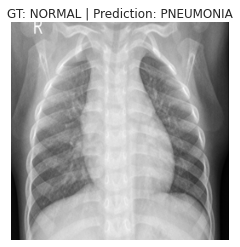

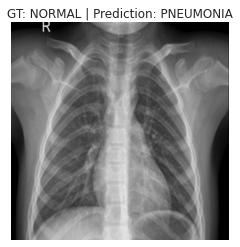

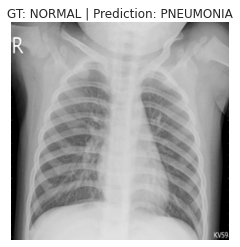

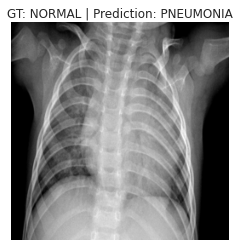

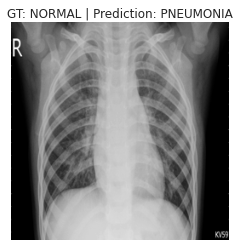

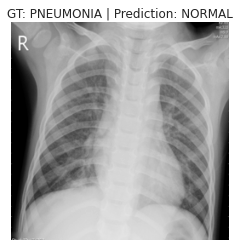

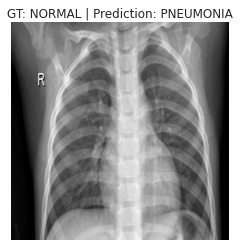

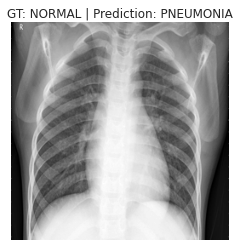

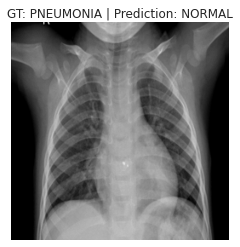

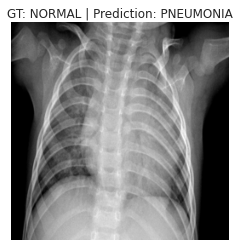

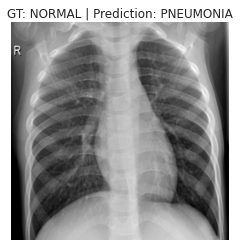

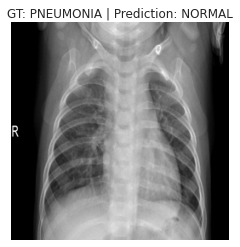

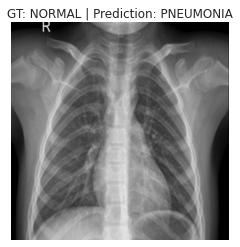

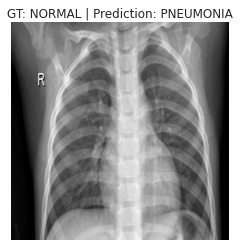

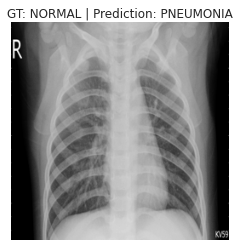

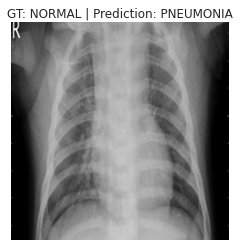

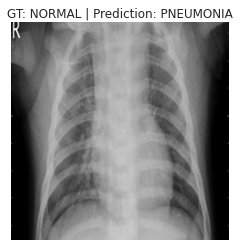

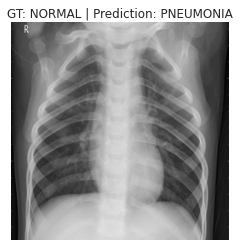

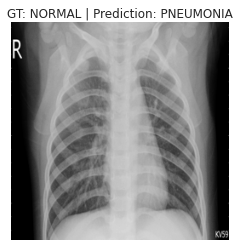

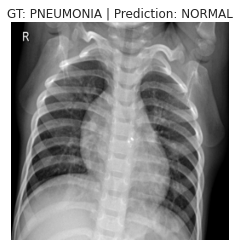

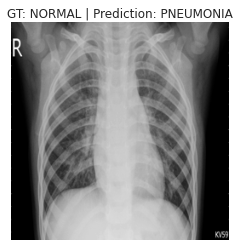

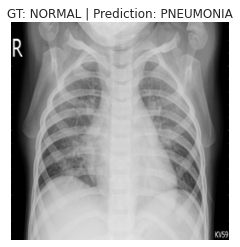

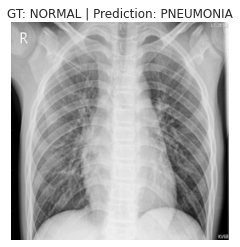

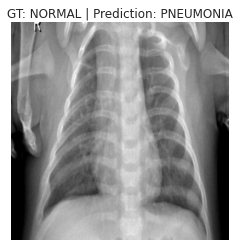

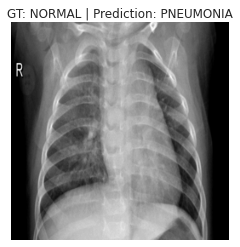

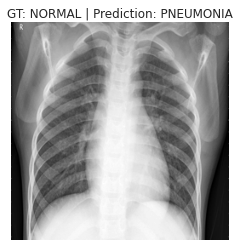

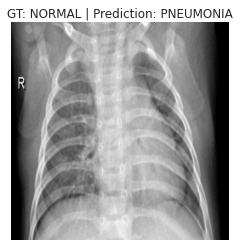

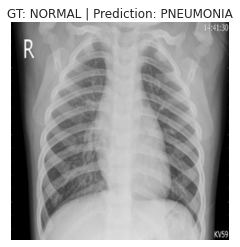

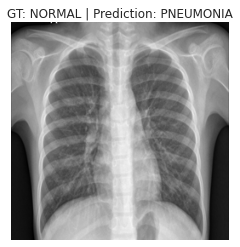

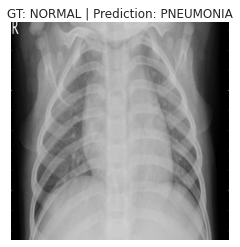

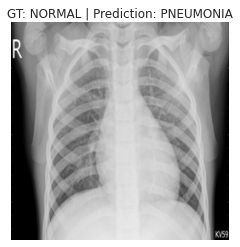

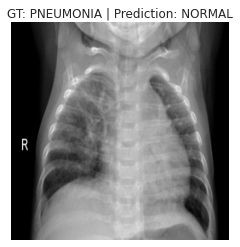

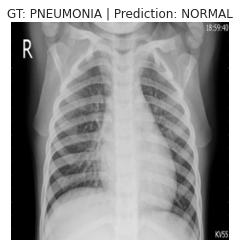

In [12]:
for i in range(len(df)):
    if df.Label.iloc[i] != df.preds.iloc[i]:
        img = Image.open(df.image_path.iloc[i]).convert("L").resize((256, 256))
        img_arr = np.array(img)

        plt.imshow(img_arr, cmap="gray")
        plt.title(f"GT: {df.Label.iloc[i]} | Prediction: {df.preds.iloc[i]}")
        plt.axis('off')
        plt.imsave(f"/user/icarrara/home/Documents/Teaching/Intoduction_to_ML/TP_2024/Lesson8/Data/misclassified_images/{df.image_path.iloc[i].split('/')[-2] + '/' + df.image_path.iloc[i].split('/')[-1]}", img_arr, cmap="gray")
        plt.show()

# Explainability AI

## Load Images

In [13]:
# Load the image using PIL
images = glob.glob('/user/icarrara/home/Documents/Teaching/Intoduction_to_ML/TP_2024/Lesson8/Data/misclassified_images/*/*')
sample_images = np.random.choice(images, size=32)

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_batch = []
for each in sample_images:
    image = Image.open(each).convert("L").resize((256, 256))
    img = np.array(image)
    img = (((img - img.min()) / img.max() - img.min())*255).astype(np.uint8)
    # Stack the Gray scaled 1 channel image 3 times to convert to 3 channel image
    img = np.stack((img, )*3)
    img = np.transpose(img, (1, 2, 0))
    print(img.shape)
    input_tensor = preprocess(img)
    input_batch.append(input_tensor.unsqueeze(0))

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [14]:
input_batch[0].shape

torch.Size([1, 3, 256, 256])

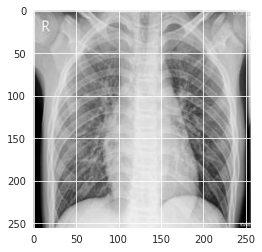

In [15]:
plt.imshow(input_batch[0][0, 0, :, :], cmap="gray")

In [16]:
# Load a pre-trained Deep Learning model (e.g., ResNet50)
DENSENET121 = models.densenet121()
DENSENET121.classifier = nn.Sequential(
        nn.Linear(in_features=(DENSENET121.classifier.in_features),out_features=512),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512,out_features=256),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=256,out_features=128),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=128,out_features=2)
    )
model = DENSENET121
model = model.to(DEVICE)
model_config = torch.load('/user/icarrara/home/Documents/Teaching/Intoduction_to_ML/TP_2024/Lesson8/Models/V0/densenet121/2023-06-30 10_50_46.047269/best_model_config.pth.tar', map_location=DEVICE)
model.load_state_dict(model_config['model_weights'])
model.eval()
model.features.denseblock4.denselayer16.eval()

# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

cams = []
counter = 0
images_tensor = []
for each in input_batch:
    rgb_img = Image.open(sample_images[counter]).resize((256, 256))
    rgb_img = np.array(rgb_img)
    rgb_img = ((rgb_img - rgb_img.min()) / rgb_img.max() - rgb_img.min())

    targets = [ClassifierOutputTarget(1)]
    #target_layers = [model.features.denseblock4.denselayer16.conv1, model.features.denseblock4.denselayer16.norm2]
    target_layers = [model.features.denseblock4.denselayer16.conv1]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=each.to(DEVICE), targets=targets)
        cam_image = show_cam_on_image(np.array(rgb_img), grayscale_cams[0, :], use_rgb=True)
        print(grayscale_cams.shape)
        print(rgb_img.shape)
        print(cam_image.shape)
        cams.append(cam_image)

    images_tensor.append(each[0, 0, :, :])
    counter += 1

(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 256, 3)
(1, 256, 256)
(256, 256, 3)
(256, 

/tmp/ipykernel_32378/1535353294.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_32378/1535353294.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))


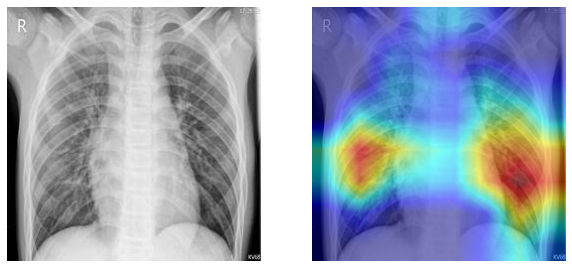

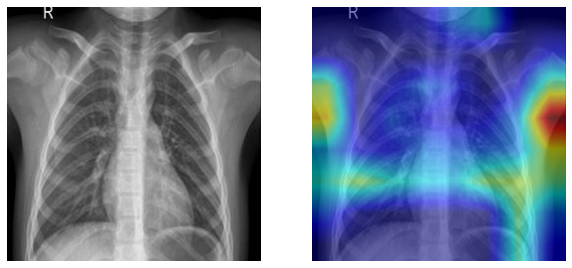

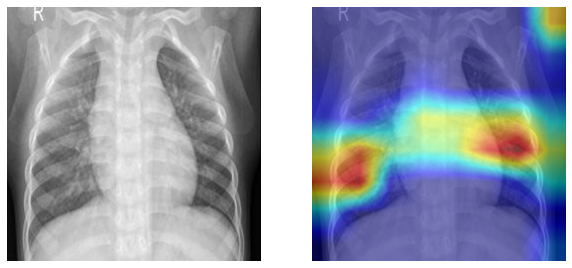

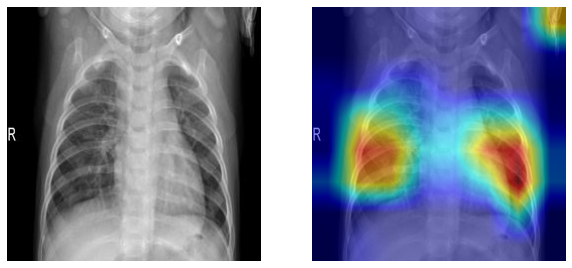

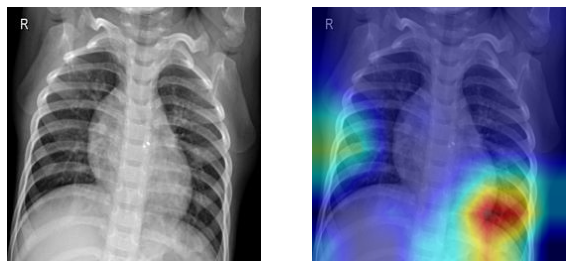

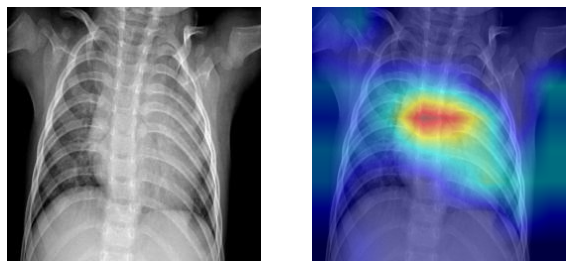

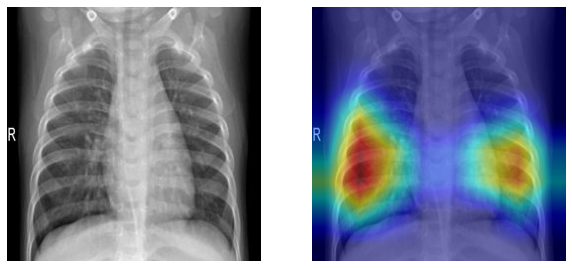

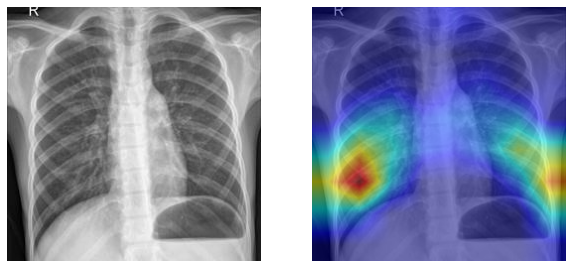

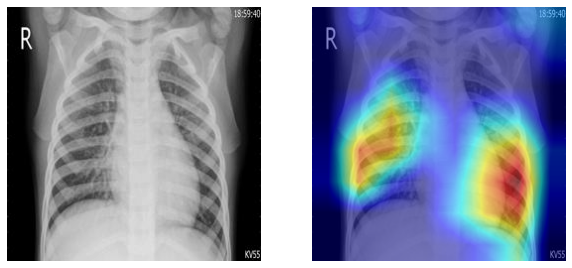

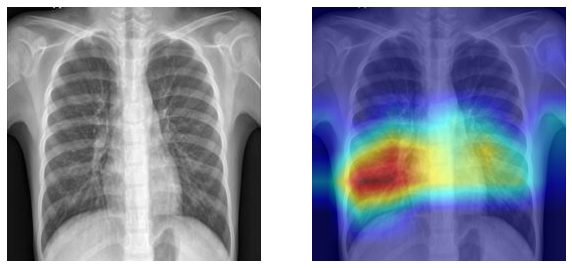

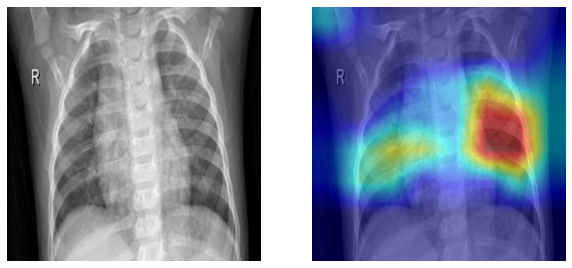

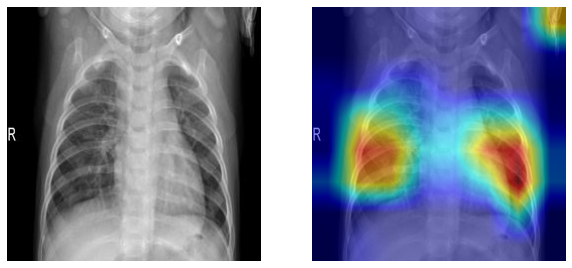

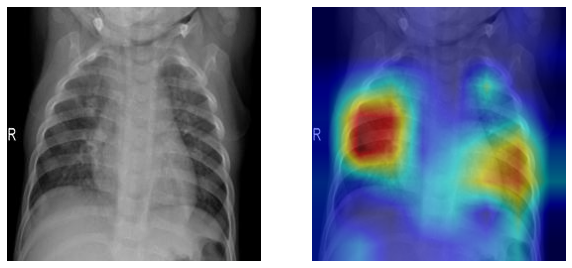

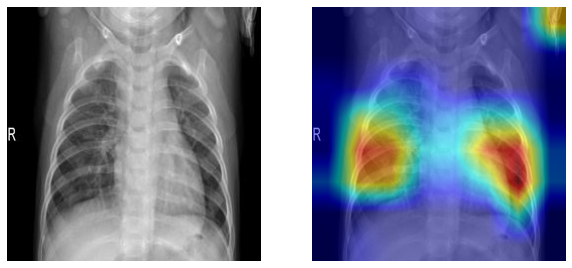

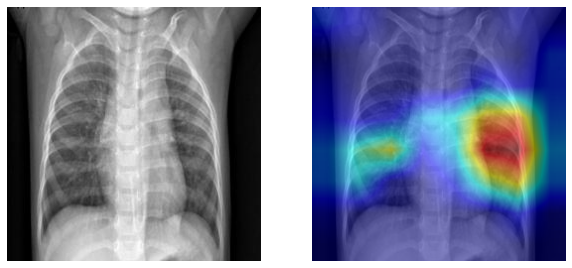

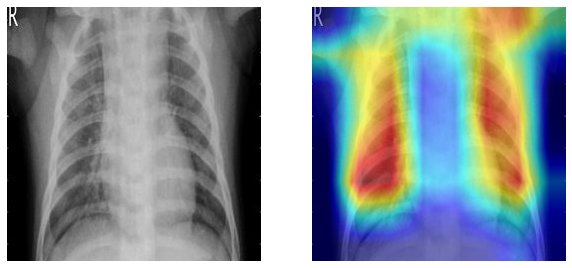

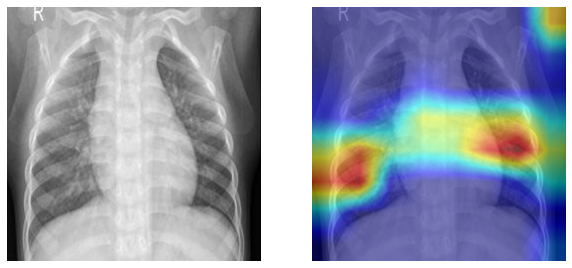

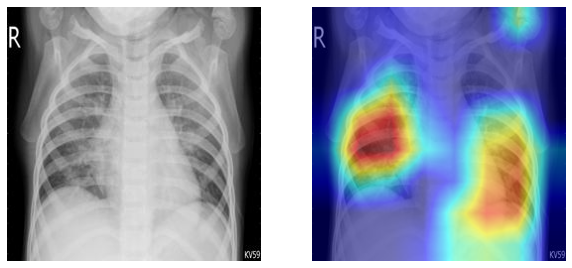

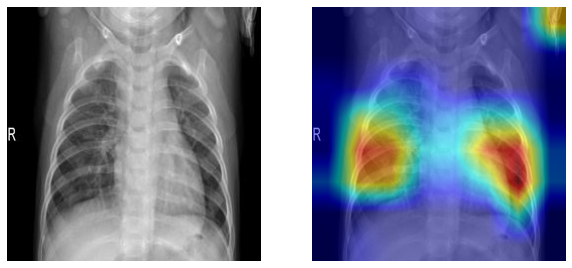

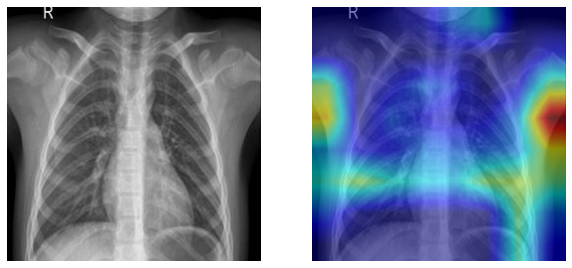

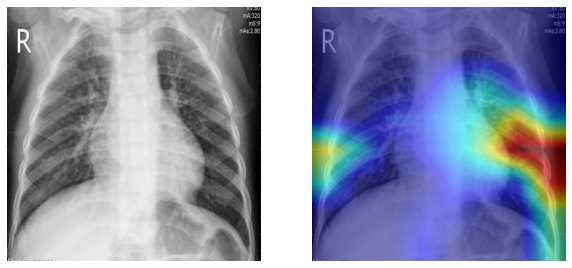

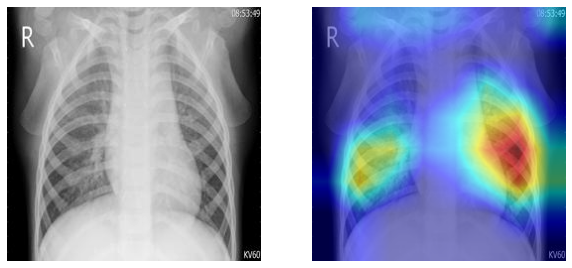

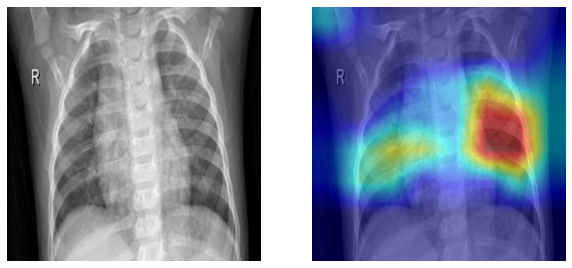

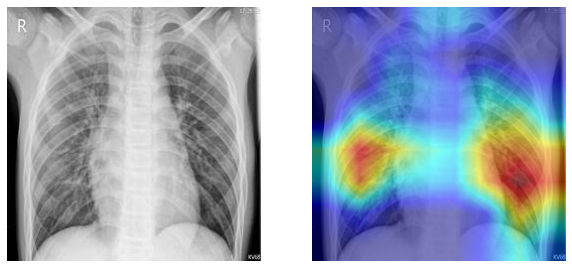

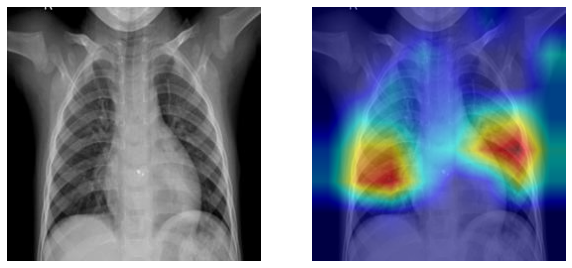

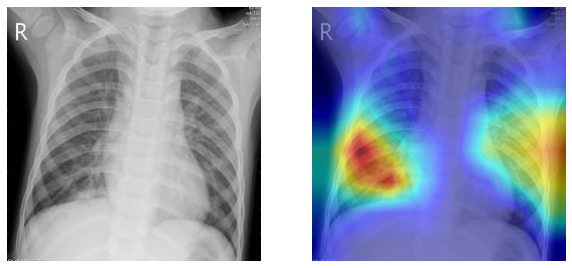

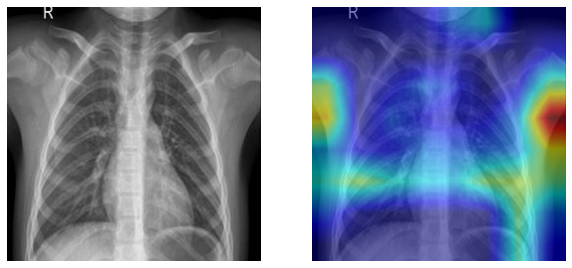

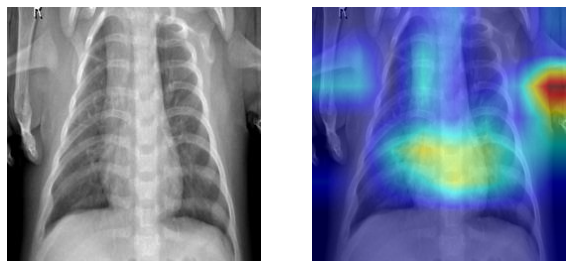

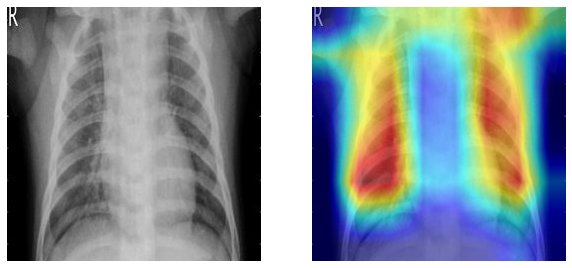

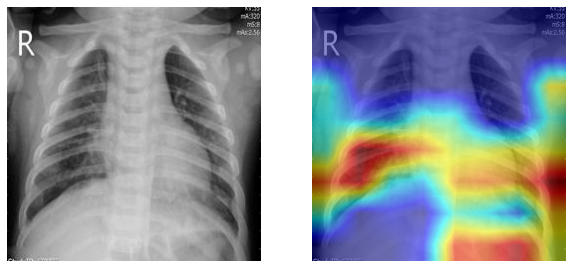

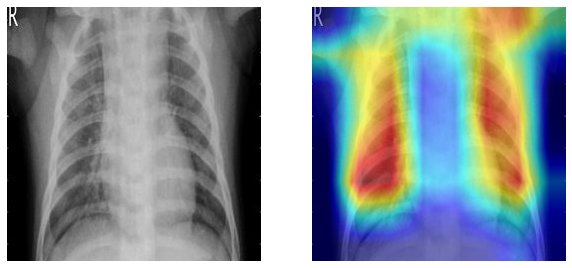

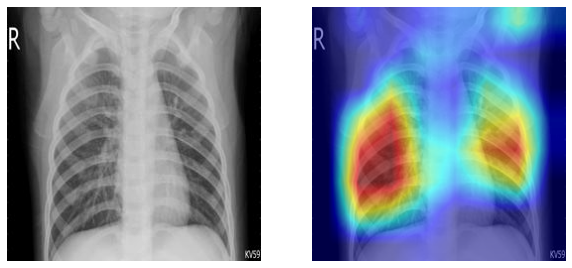

In [17]:
for cam, img in zip(cams, images_tensor):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, cmap="gray")
    ax[0].axis("off")
    ax[1].imshow(cam)
    ax[1].axis("off")
    fig.show()